In [1]:
%load_ext tensorboard
import datetime
import os
import numpy as np
from sklearn.model_selection import train_test_split 
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LayerNormalization
from keras import optimizers
from keras.utils import to_categorical

2024-02-15 22:05:28.350161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 22:05:28.350202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 22:05:28.351277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 22:05:28.357445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 22:05:29.083812: W tensorflow/compiler/tf2

In [2]:
import h5py
def load_dataset():
    fn =   'train_signs.h5'
    train_dataset = h5py.File(fn, "r")
    X_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    Y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels

    fn ='test_signs.h5'
    test_dataset =  h5py.File(fn, "r")
    X_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    Y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    Y_train = Y_train.reshape(-1,)
    Y_test = Y_test.reshape(-1,)
    
    return X_train, Y_train, X_test, Y_test, classes
train_data, train_labels, test_data, test_labels, classes = load_dataset()

print ('train_data.shape=', train_data.shape)
print ('train_labels.shape=',  train_labels.shape)
print ('test_data.shape=', test_data.shape)
print ('test_labels.shape=', test_labels.shape)

train_data.shape= (1080, 64, 64, 3)
train_labels.shape= (1080,)
test_data.shape= (120, 64, 64, 3)
test_labels.shape= (120,)


In [3]:
def display_samples_in_grid(X, n_rows, n_cols= None, y = None ):
    if n_cols is None:
        n_cols= n_rows
    indices = np.random.randint(0, len(X),n_rows*n_cols)
    for i in range (n_rows):
        for j in range (n_cols):
            index = n_cols*i+j
            ax = plt.subplot(n_rows,n_cols,index+1)
            ax.imshow(X[indices[index]], cmap='Greys')
            if not (y is None):
                plt.title(y[indices[index]])
            plt.axis('off')

In [4]:
y_train_onehot_labels = to_categorical(train_labels.T, num_classes=6)
y_test_onehot_labels = to_categorical(test_labels.T, num_classes=6)

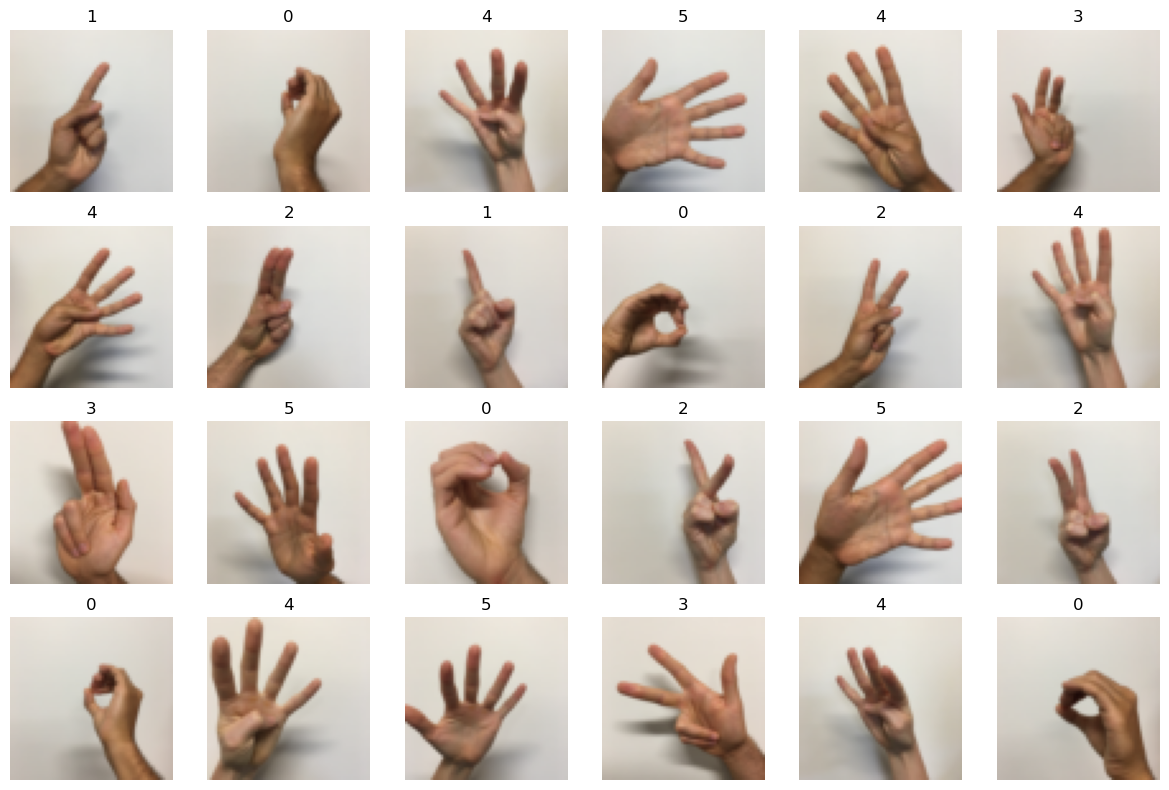

In [5]:
plt.figure(figsize= (12,8))
display_samples_in_grid(train_data, n_rows=4, n_cols=6, y= train_labels.T)
plt.tight_layout(h_pad=1, w_pad=1)

In [6]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(LayerNormalization(axis=1))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(LayerNormalization(axis=1))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(LayerNormalization(axis=1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(6)) 
model.add(Activation("softmax"))
model.summary()

2024-02-15 22:05:39.171428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 22:05:39.215051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 22:05:39.215368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 layer_normalization (Layer  (None, 31, 31, 32)        62        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                        

In [7]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [8]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
history = model.fit(train_data, y_train_onehot_labels, batch_size=32, epochs=20, validation_data=(test_data, y_test_onehot_labels), 
          callbacks=[tensorboard_callback])

2024-02-15 22:05:52.957850: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/20


2024-02-15 22:05:54.881711: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 22:05:55.019749: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-15 22:05:56.426102: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4cf4d30220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 22:05:56.426134: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-02-15 22:05:56.431751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708027556.528351   11896 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 [==============================] - 6s 31ms/step - loss: 1.4821 - accuracy: 0.4537 - val_loss: 0.7744 - val_accuracy: 0.7000
Epoch 2/20
34/34 [==============================] - 1s 15ms/step - loss: 0.7462 - accuracy: 0.7148 - val_loss: 0.3871 - val_accuracy: 0.8500
Epoch 3/20
34/34 [==============================] - 1s 15ms/step - loss: 0.4474 - accuracy: 0.8426 - val_loss: 0.2802 - val_accuracy: 0.8833
Epoch 4/20
34/34 [==============================] - 1s 15ms/step - loss: 0.2726 - accuracy: 0.9074 - val_loss: 0.2037 - val_accuracy: 0.9250
Epoch 5/20
34/34 [==============================] - 1s 15ms/step - loss: 0.2450 - accuracy: 0.9120 - val_loss: 0.2962 - val_accuracy: 0.8917
Epoch 6/20
34/34 [==============================] - 1s 15ms/step - loss: 0.1773 - accuracy: 0.9361 - val_loss: 0.1599 - val_accuracy: 0.9500
Epoch 7/20
34/34 [==============================] - 0s 15ms/step - loss: 0.1473 - accuracy: 0.9463 - val_loss: 0.2919 - val_accuracy: 0.8667
Epoch 8/20
34/34 [======

In [10]:
%tensorboard --logdir logs/fit

Text(0.5, 1.0, 'Accuracy Curves')

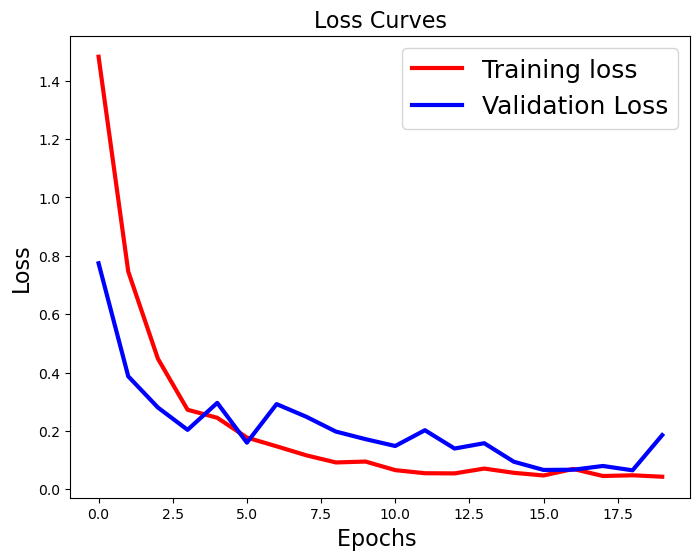

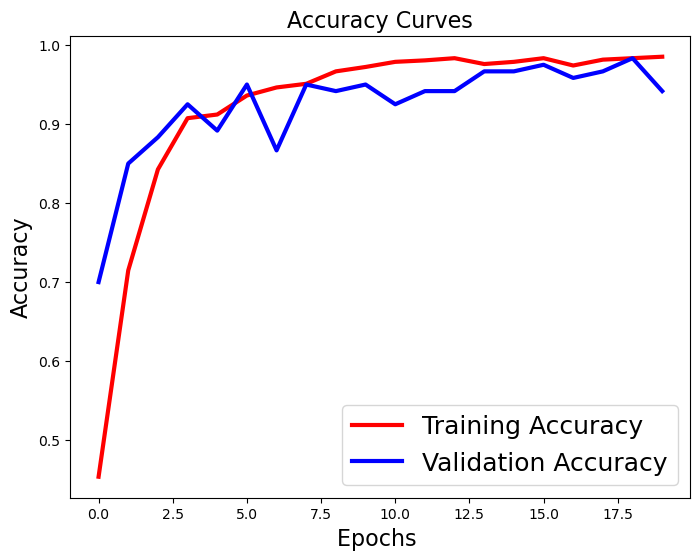

In [11]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [12]:
val_loss, val_acc = model.evaluate(test_data, y_test_onehot_labels, verbose=0)
print('Val loss:', val_loss)
print('Val accuracy:', val_acc)

Val loss: 0.1857081949710846
Val accuracy: 0.9416666626930237
